# 06 Profit of future

In [1]:
from datetime import datetime
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from util import *
from nbeat import *

bnb_data = pd.read_csv('data/BNBUSDT_1D_2.csv')
bnb_close_values = bnb_data['Close']

### Profit of future

```
F(t) = P(t+f) - P(t)
F - future profit
P - price
t - time
f - future period
```

Study the future profit in log scale as the magnitude of it is not important.

```
log_scale(x)
  = log(x + 1)     for possitive x
  = -log(-x + 1)   for negative x
```

One is added to x to keep the log scale positive

In [2]:
def covertToLogScale(data):
  return np.array([np.log(abs(v) + 1)*np.sign(v) for v in data])

def plotBarColoredSign(data):
  colors = ['green' if value > 0 else 'red' for value in data]
  plt.bar(range(len(data)), data, color=colors)

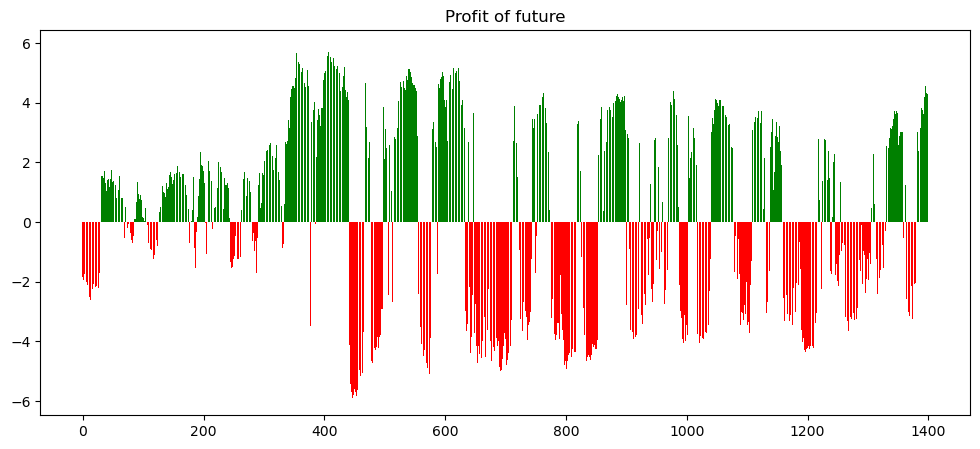

In [3]:
future_period = 21
profit_of_future = np.array([bnb_close_values[i+future_period] - bnb_close_values[i] for i in range(len(bnb_close_values)-future_period)])

# reduce profit of future in log scale
profit_of_future_log = covertToLogScale(profit_of_future)

plt.figure(figsize=(12, 5))
plotBarColoredSign(profit_of_future_log)
plt.title('Profit of future')
plt.show()

Brenchmarking with trivial prediction: profit of future = 0

In [4]:
output_scale = np.max(profit_of_future_log)

rmse0 = np.sqrt(np.mean(np.square(profit_of_future_log / output_scale)))
rmse0

0.543541301515181

#### [Model1] Using price value to predict profit of future

In [5]:
input_data = np.array(bnb_data['Close'][0:-future_period]) 
dataSize = len(input_data)
assert(dataSize == len(profit_of_future_log))
windowSize = future_period * 2 # TODO:
testSize = round(dataSize * 0.3)
print(f"dataSize: {dataSize}")
print(f"windowSize: {windowSize}")
print(f"testSize: {testSize}")

input_scale = np.max(input_data)
output_scale = np.max(profit_of_future_log)
print(f"input_scale: {input_scale}")
print(f"output_scale: {output_scale}")

dataSize: 1400
windowSize: 42
testSize: 420
input_scale: 676.967
output_scale: 5.841402995389024


In [6]:
x_train, y_train, x_test, y_test, train_dataset, test_dataset = prepareDatasForSeriesModelTraining(input_data / input_scale, profit_of_future_log / output_scale, windowSize, testSize)

nbeatNeuronCount = 512
nBeatLayerCount = 4
nBeatStackCount = 30

# Create input to stacks
input = layers.Input(shape=(windowSize), name="stack_input")
x = input
x = buildNBeatLayers(windowSize, windowSize+1, 1, nbeatNeuronCount, nBeatLayerCount, nBeatStackCount, x)

model1 = tf.keras.Model(inputs=input, outputs=x)
model1.compile(loss="mse",
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=["mse"])
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 stack_input (InputLayer)       [(None, 42)]         0           []                               
                                                                                                  
 InitialBlock (NBeatsBlock)     ((None, 42),         832043      ['stack_input[0][0]']            
                                 (None, 1))                                                       
                                                                                                  
 nbeat_subtract_00 (Subtract)   (None, 42)           0           ['stack_input[0][0]',            
                                                                  'InitialBlock[0][0]']           
                                                                                              


Epoch 14: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 19: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 24: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch: 9.

Epoch 29: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 29: early stopping
Early stopping restore at 8 epochs
14/14 [==============================] - 2s 21ms/step - loss: 0.2388 - mse: 0.2388
loss: 0.48863983720125465
corr: 0.25497603355171156


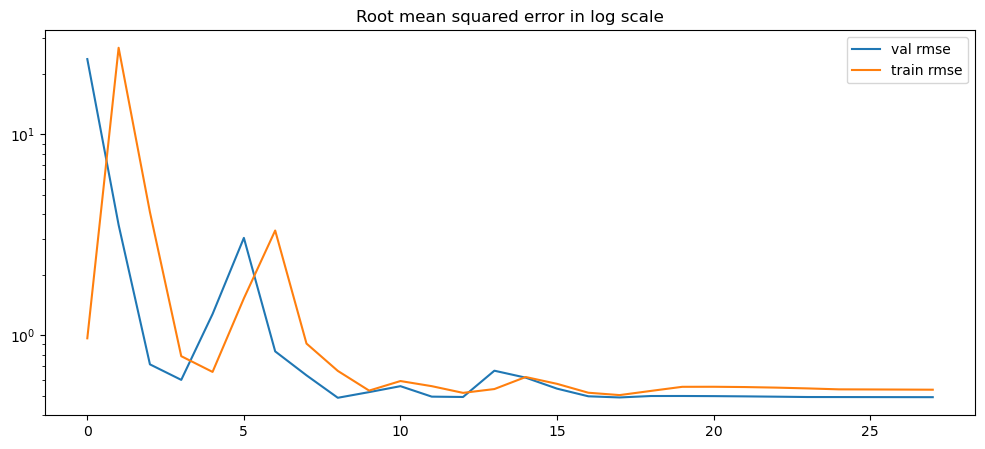

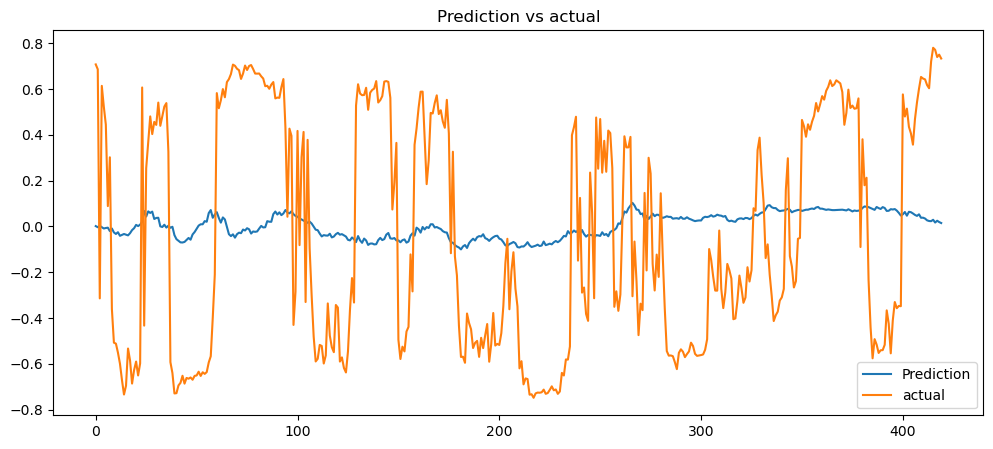

In [7]:
history1, rmse1, corr1 = standardTrainingAndReport(model1, x_test, y_test, train_dataset, test_dataset)

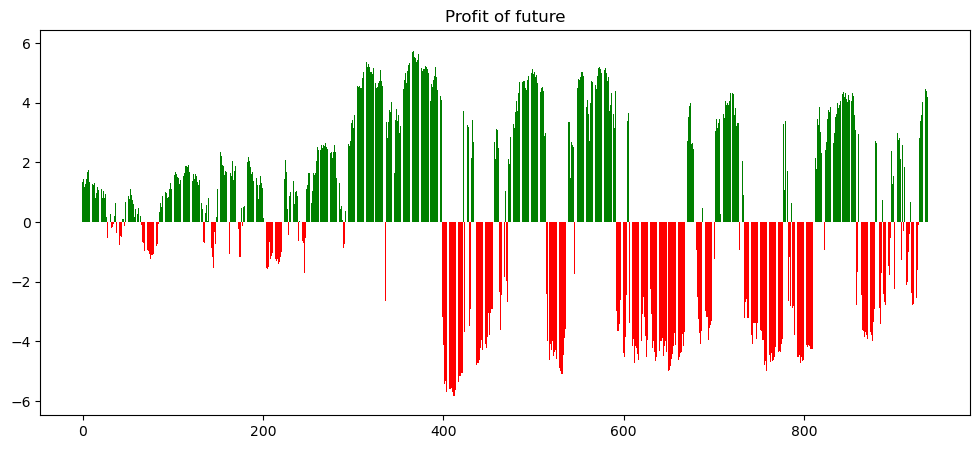

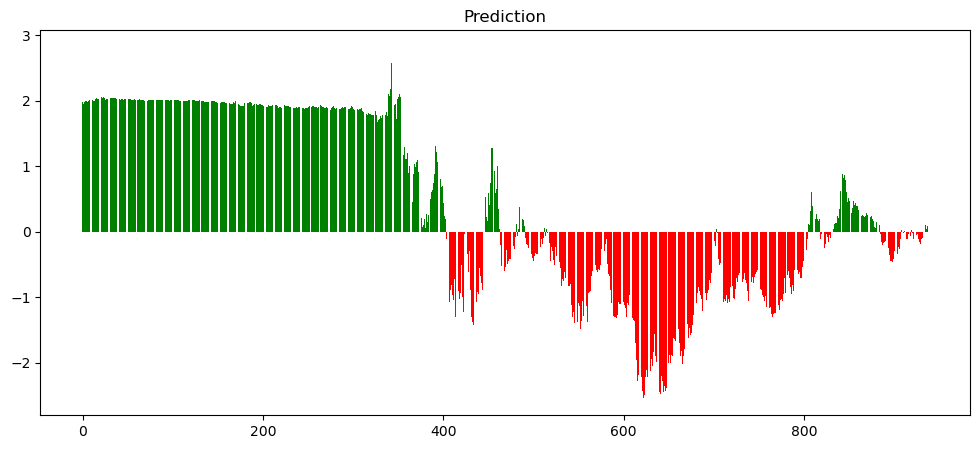

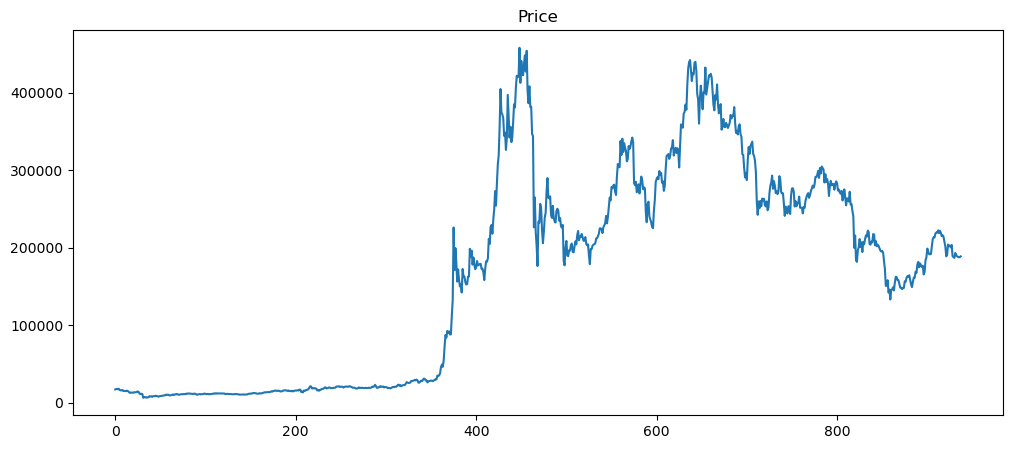

In [8]:
# check the training performance

plt.figure(figsize=(12, 5))
plotBarColoredSign(y_train * output_scale)
plt.title('Profit of future')
plt.show()

prediction = model1.predict(x_train)
prediction = prediction.reshape(-1) * output_scale
plt.figure(figsize=(12, 5))
plotBarColoredSign(prediction)
plt.title('Prediction')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(input_data[0:len(x_train)] * input_scale)
plt.title('Price')
plt.show()


The first 390 data seems dominating the possitive results. Ignore the first 390 data for the next model

In [9]:
skip_count = 390

input_data = np.array(bnb_data['Close'][skip_count:-future_period])
output_data = np.array(profit_of_future_log[skip_count:])

dataSize = len(input_data)
assert(dataSize == len(output_data))
windowSize = future_period * 2 # TODO:
testSize = round(dataSize * 0.3)
print(f"dataSize: {dataSize}")
print(f"windowSize: {windowSize}")
print(f"testSize: {testSize}")

input_scale = np.max(input_data)
output_scale = np.max(output_data)
print(f"input_scale: {input_scale}")
print(f"output_scale: {output_scale}")

dataSize: 1010
windowSize: 42
testSize: 303
input_scale: 676.967
output_scale: 5.841402995389024


In [10]:
x_train, y_train, x_test, y_test, train_dataset, test_dataset = prepareDatasForSeriesModelTraining(input_data / input_scale, output_data / output_scale, windowSize, testSize)

nbeatNeuronCount = 512
nBeatLayerCount = 4
nBeatStackCount = 30

# Create input to stacks
input = layers.Input(shape=(windowSize), name="stack_input")
x = input
x = buildNBeatLayers(windowSize, windowSize+1, 1, nbeatNeuronCount, nBeatLayerCount, nBeatStackCount, x)

model2 = tf.keras.Model(inputs=input, outputs=x)
model2.compile(loss="mse",
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=["mse"])
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 stack_input (InputLayer)       [(None, 42)]         0           []                               
                                                                                                  
 InitialBlock (NBeatsBlock)     ((None, 42),         832043      ['stack_input[0][0]']            
                                 (None, 1))                                                       
                                                                                                  
 nbeat_subtract_00 (Subtract)   (None, 42)           0           ['stack_input[0][0]',            
                                                                  'InitialBlock[0][0]']           
                                                                                            


Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 16: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 21: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch: 6.

Epoch 26: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 26: early stopping
Early stopping restore at 5 epochs
10/10 [==============================] - 2s 17ms/step - loss: 0.2082 - mse: 0.2082
loss: 0.4562594262547214
corr: 0.24936035756300304


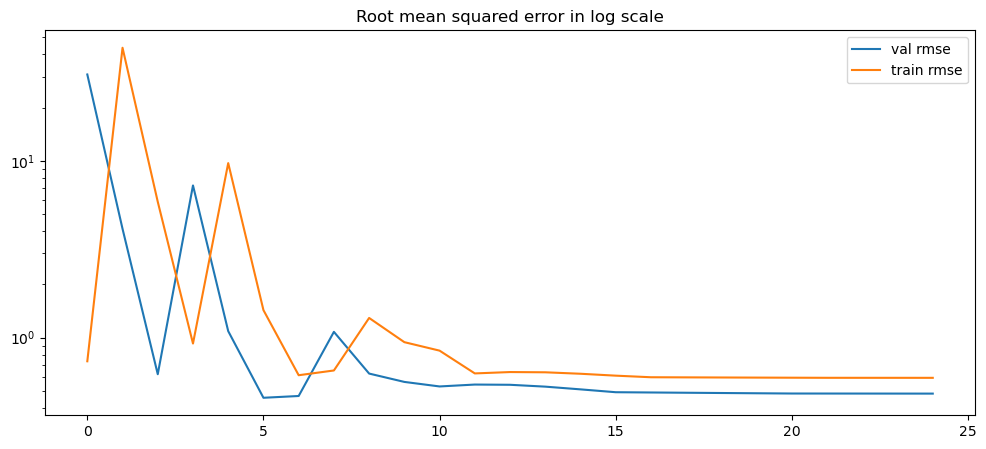

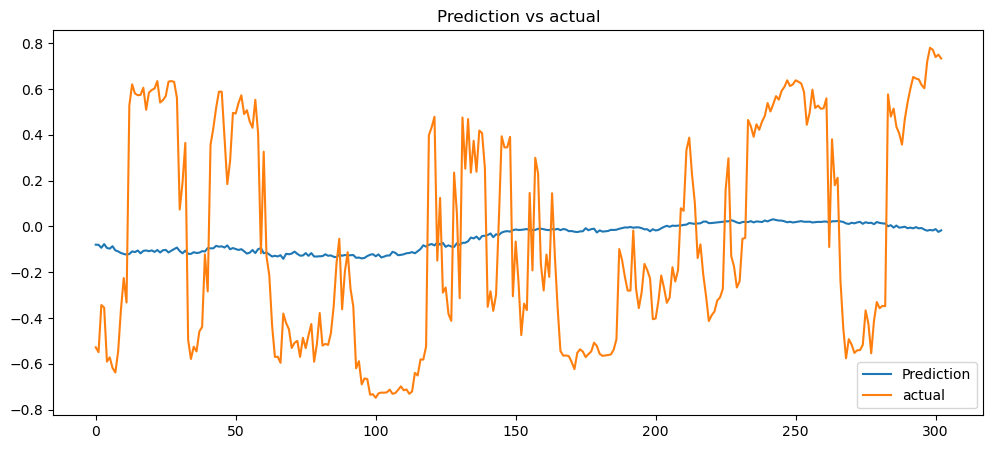

In [11]:
history2, rmse2, corr2 = standardTrainingAndReport(model2, x_test, y_test, train_dataset, test_dataset)

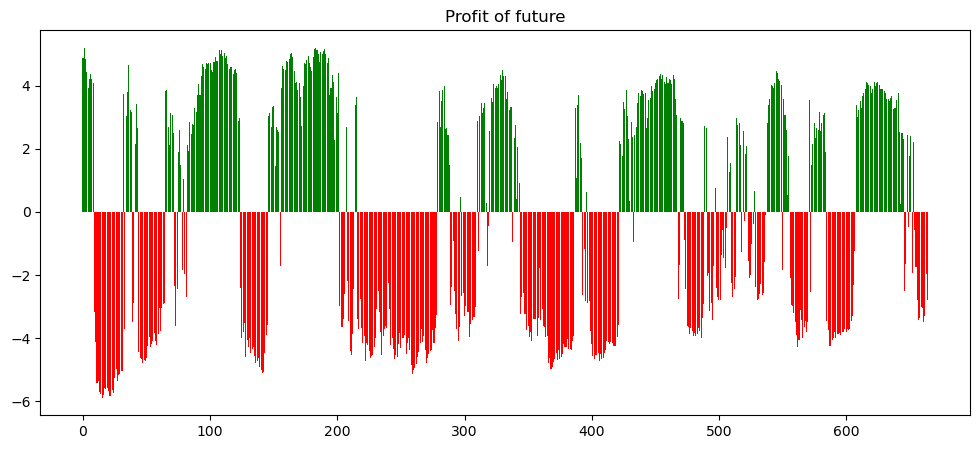

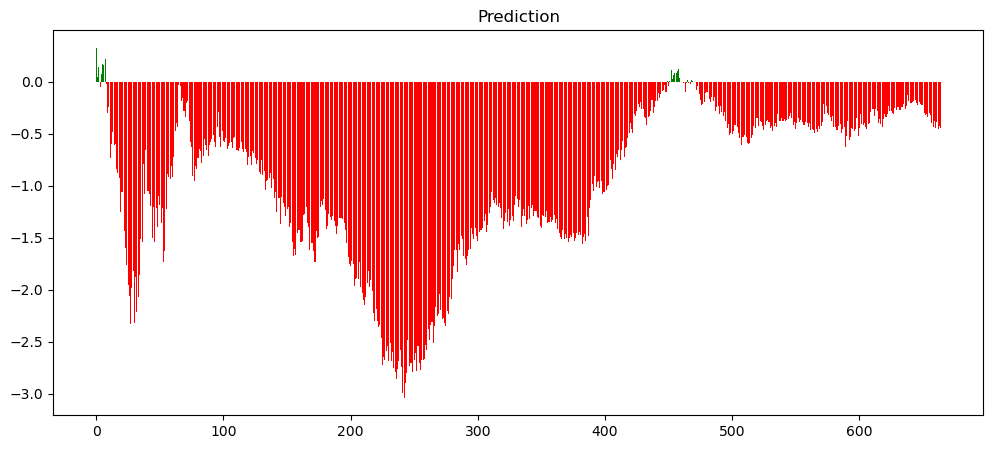

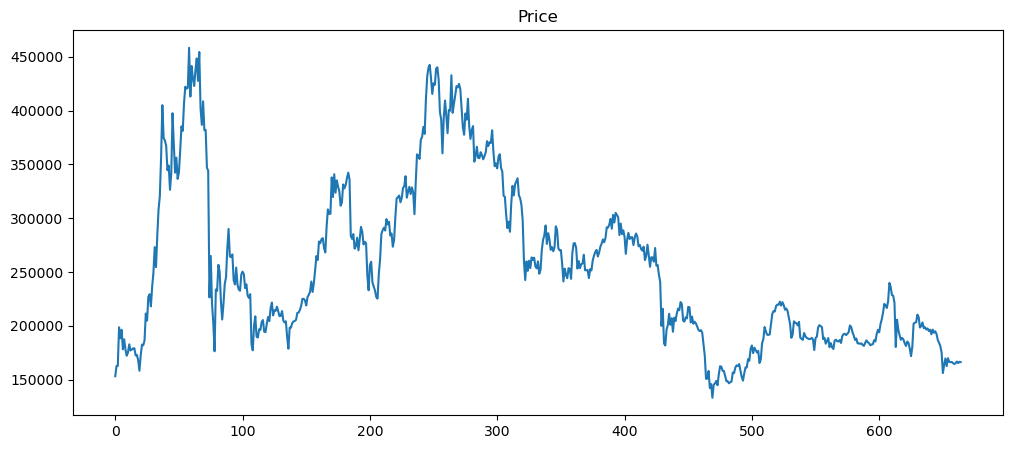

In [12]:
# check the training performance

plt.figure(figsize=(12, 5))
plotBarColoredSign(y_train * output_scale)
plt.title('Profit of future')
plt.show()

prediction = model2.predict(x_train)
prediction = prediction.reshape(-1) * output_scale
plt.figure(figsize=(12, 5))
plotBarColoredSign(prediction)
plt.title('Prediction')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(input_data[0:len(x_train)] * input_scale)
plt.title('Price')
plt.show()


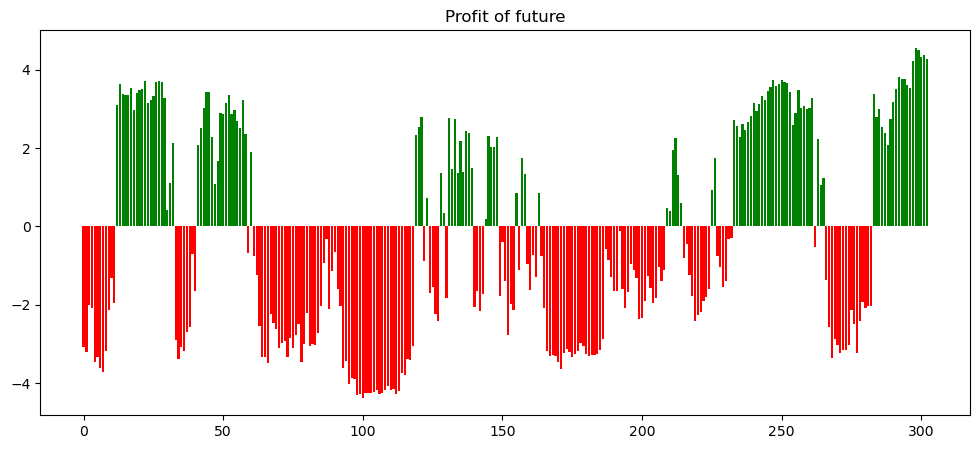

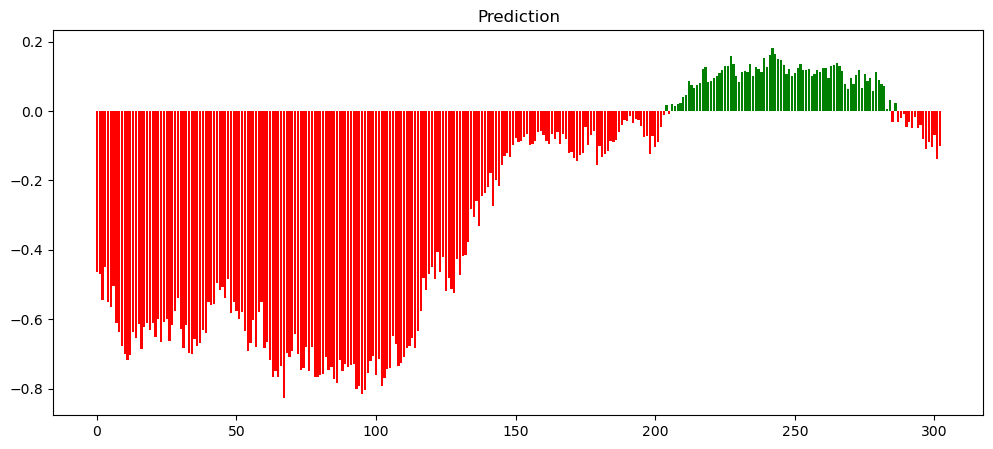

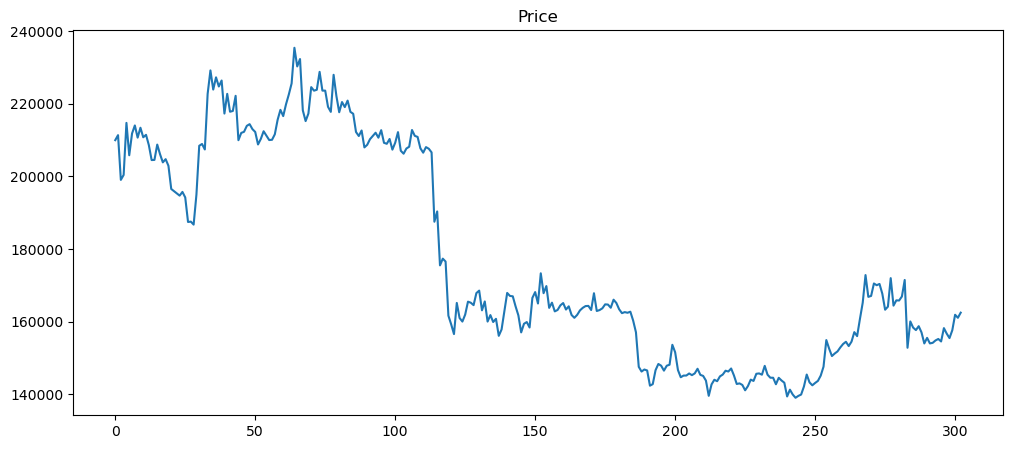

In [13]:
# check the testing performance

plt.figure(figsize=(12, 5))
plotBarColoredSign(y_test * output_scale)
plt.title('Profit of future')
plt.show()

prediction = model2.predict(x_test)
prediction = prediction.reshape(-1) * output_scale
plt.figure(figsize=(12, 5))
plotBarColoredSign(prediction)
plt.title('Prediction')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(input_data[-len(x_test):] * input_scale)
plt.title('Price')
plt.show()


The prediction seems bias to negative values and the correlation is not good, but it beats trivial prediction.

Try trainning again with a smaller learning rate from this weights

In [ ]:
# model2.save('models/model6-2')
# model2.load_weights('models/model6-2')

In [31]:
model2.compile(loss="mse",
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=["mse"])


Epoch 10: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 15: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 20: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.

Epoch 25: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.
Restoring model weights from the end of the best epoch: 6.
Epoch 26: early stopping
Early stopping restore at 5 epochs
10/10 [==============================] - 2s 35ms/step - loss: 0.2153 - mse: 0.2153
loss: 0.4639903657895463
corr: 0.22535971737342259


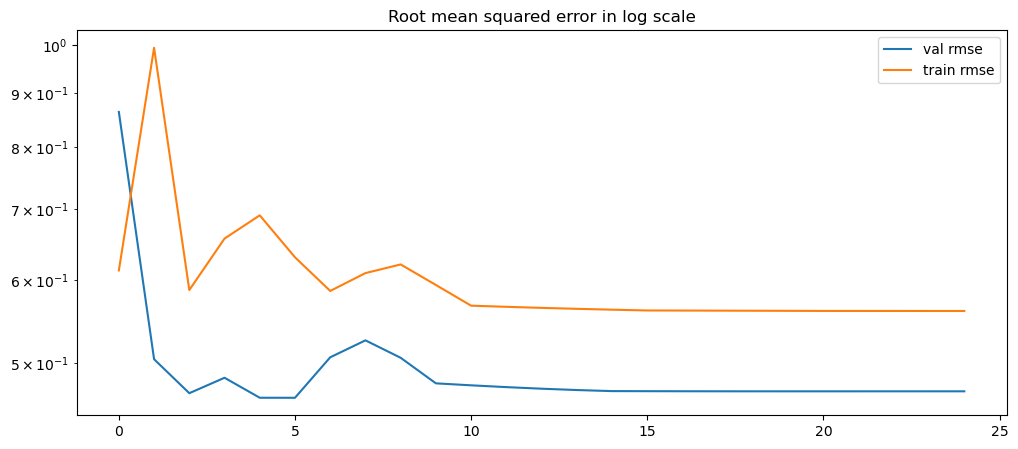

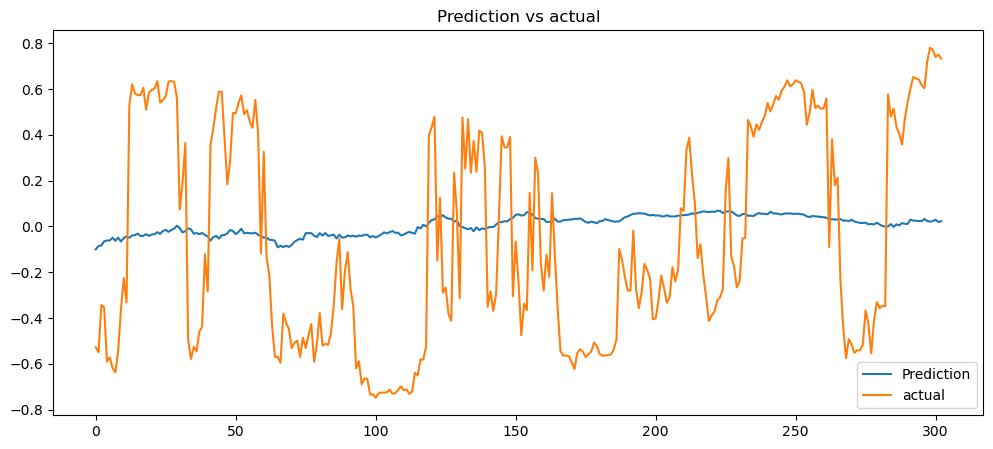

In [32]:
history2_2, rmse2_2, corr2_2 = standardTrainingAndReport(model2, x_test, y_test, train_dataset, test_dataset)

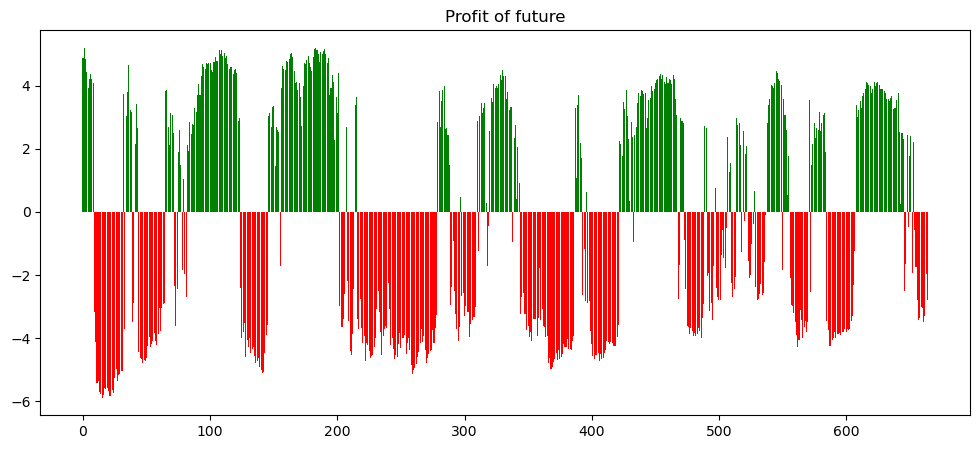

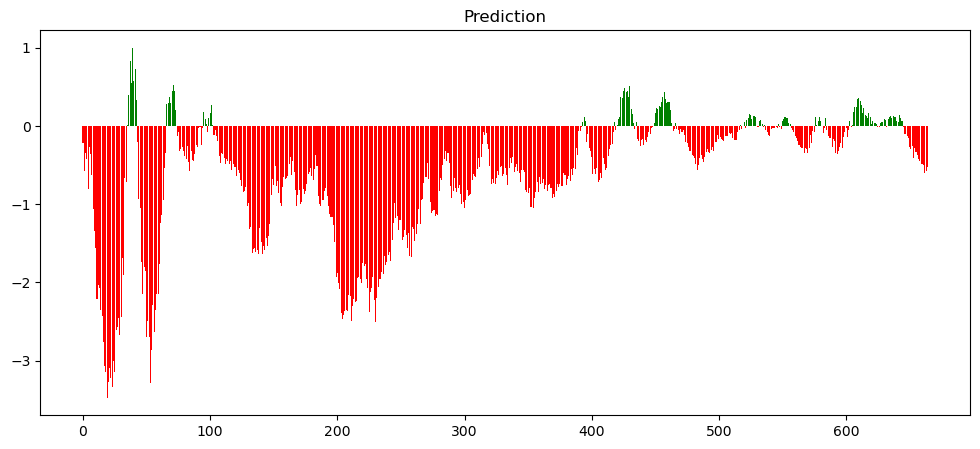

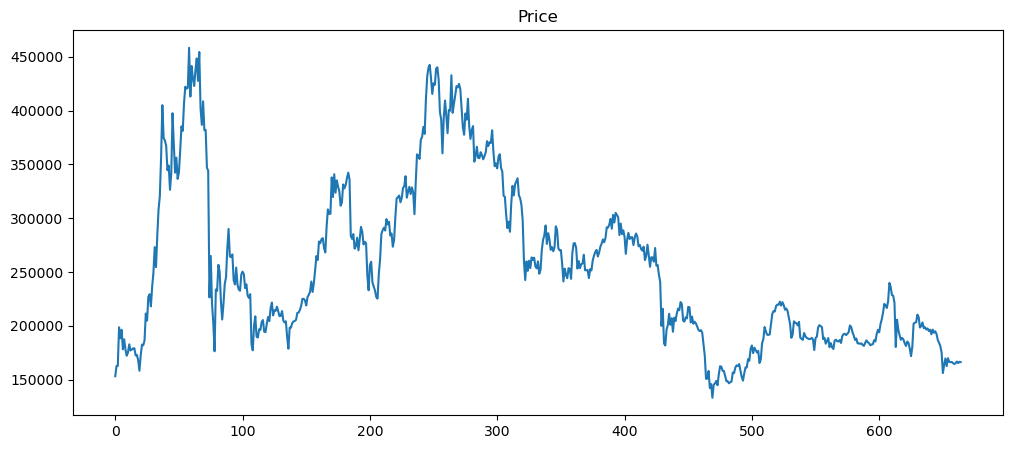

In [33]:
# check the training performance

plt.figure(figsize=(12, 5))
plotBarColoredSign(y_train * output_scale)
plt.title('Profit of future')
plt.show()

prediction = model2.predict(x_train)
prediction = prediction.reshape(-1) * output_scale
plt.figure(figsize=(12, 5))
plotBarColoredSign(prediction)
plt.title('Prediction')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(input_data[0:len(x_train)] * input_scale)
plt.title('Price')
plt.show()


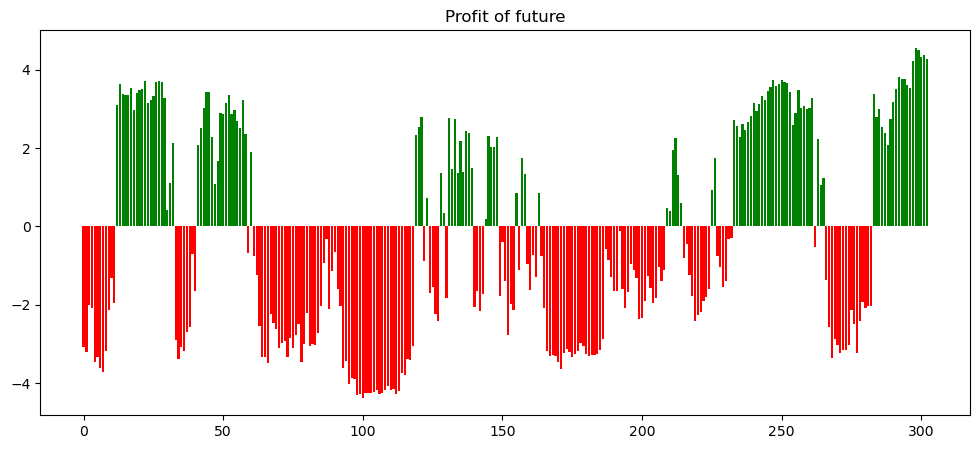

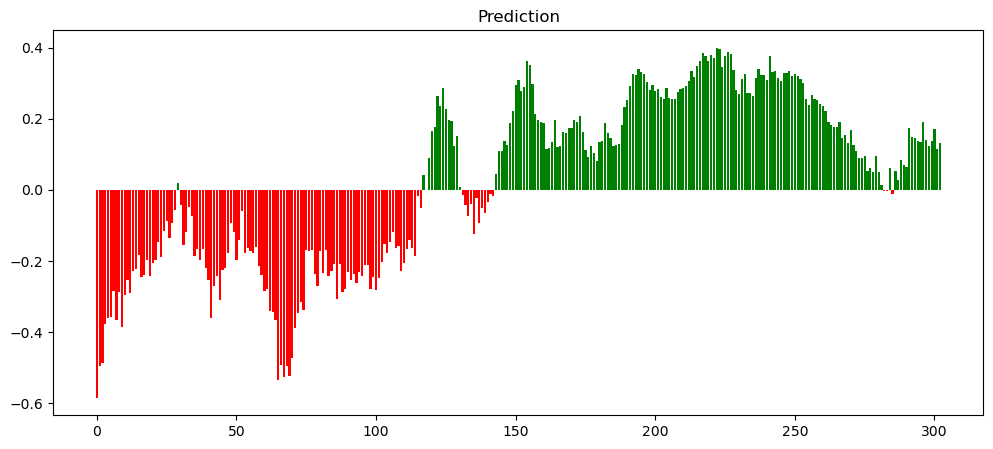

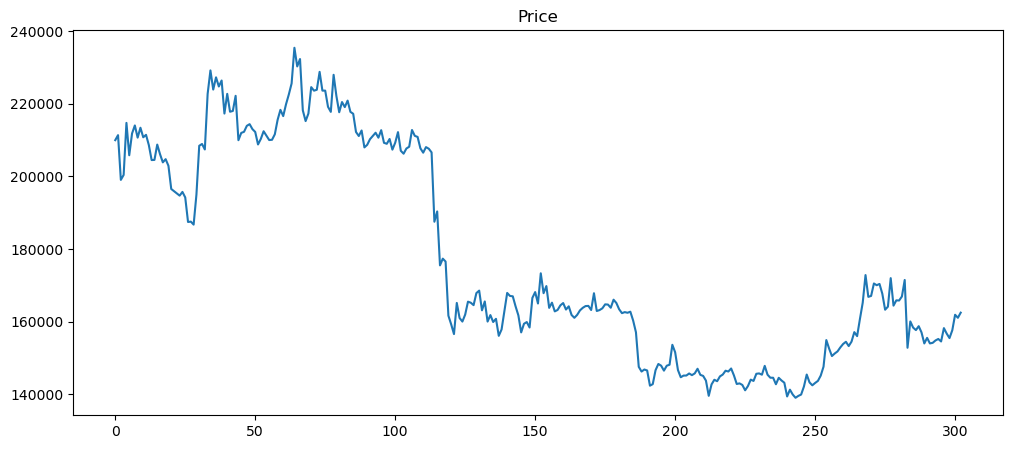

In [34]:
# check the testing performance

plt.figure(figsize=(12, 5))
plotBarColoredSign(y_test * output_scale)
plt.title('Profit of future')
plt.show()

prediction = model2.predict(x_test)
prediction = prediction.reshape(-1) * output_scale
plt.figure(figsize=(12, 5))
plotBarColoredSign(prediction)
plt.title('Prediction')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(input_data[-len(x_test):] * input_scale)
plt.title('Price')
plt.show()


This model seems overfit and the result bias to possitve

#### [Model3] Try overfitting the model first

Train the model without validation data first, and then train it again with validation data.

In [41]:
# Create input to stacks
input = layers.Input(shape=(windowSize), name="stack_input")
x = input
x = buildNBeatLayers(windowSize, windowSize+1, 1, nbeatNeuronCount, nBeatLayerCount, nBeatStackCount, x)

model3 = tf.keras.Model(inputs=input, outputs=x)
model3.compile(loss="mse",
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=["mse"])
# model2.summary()

10/10 [==============================] - 2s 21ms/step - loss: 0.3035 - mse: 0.3035
loss: 0.5509297055857727
corr: 0.1621305309964207


(<keras.callbacks.History at 0x24b2da15d60>,
 0.5509297055857727,
 0.1621305309964207)

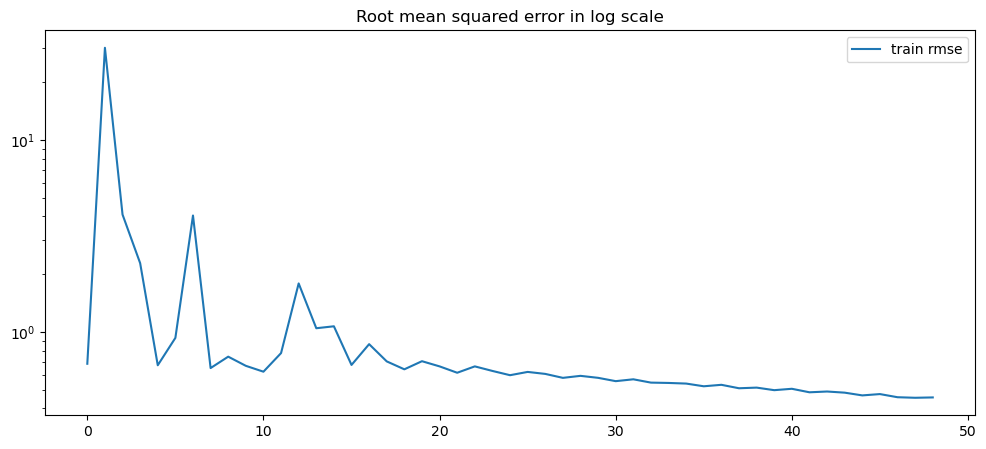

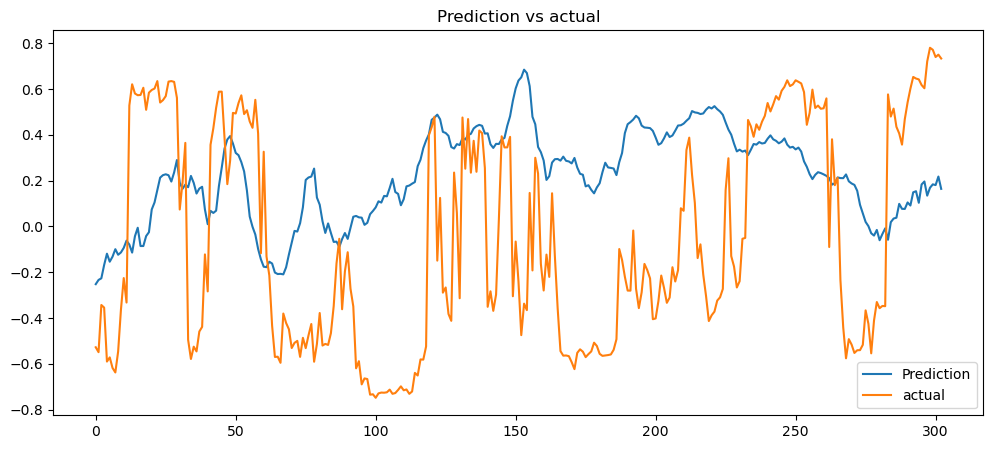

In [42]:
def noValidationTrainingAndReport(model, x_test, y_test, train_dataset, epochs=50,plotHistoryLastEpoch=0):
  history = model.fit(train_dataset,
            epochs=epochs,
            verbose=0, # prevent large amounts of training outputs
            )
  # plotHistoryRSME(history, plotHistoryLastEpoch)
  plt.figure(figsize=(12,5))
  plt.plot(np.sqrt(history.history['mse'])[-plotHistoryLastEpoch:-1], label="train rmse")
  plt.title("Root mean squared error in log scale")
  plt.legend()
  plt.yscale("log")
  #
  loss = np.sqrt(model.evaluate(x_test, y_test)[0])
  print(f"loss: {loss}")
  # plot prediction
  prediction = model.predict(x_test)
  plt.figure(figsize=(12,5))
  plt.plot(prediction, label='Prediction')
  plt.plot(y_test, label='actual')
  plt.title('Prediction vs actual')
  plt.legend()
  corr = np.corrcoef(prediction.reshape(-1), y_test)[0, 1] 
  print(f"corr: {corr}")
  return history, loss, corr

noValidationTrainingAndReport(model3, x_test, y_test, train_dataset)

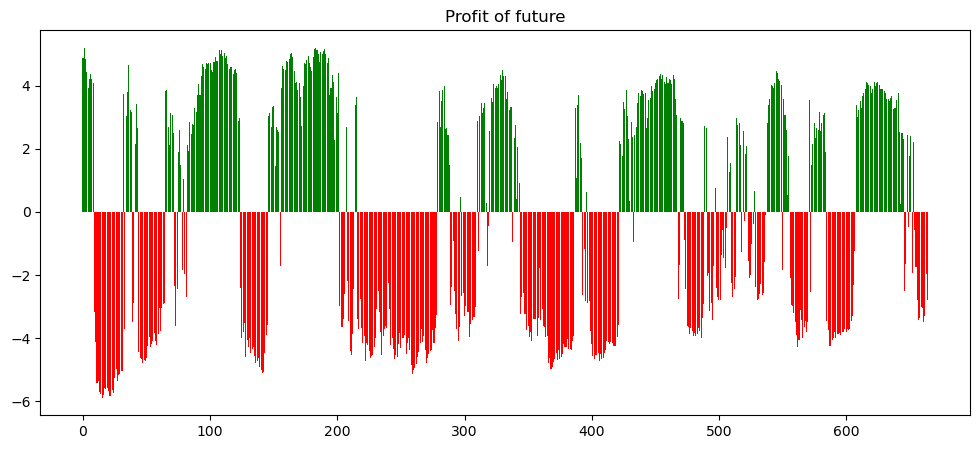

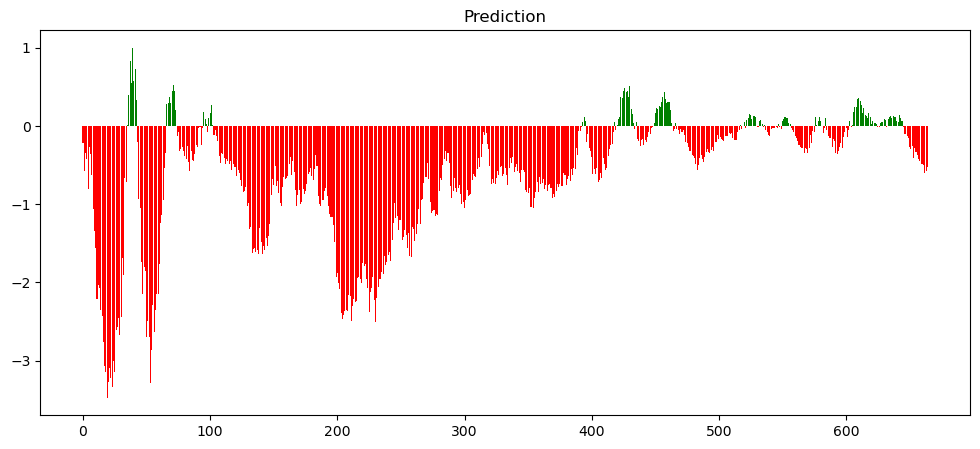

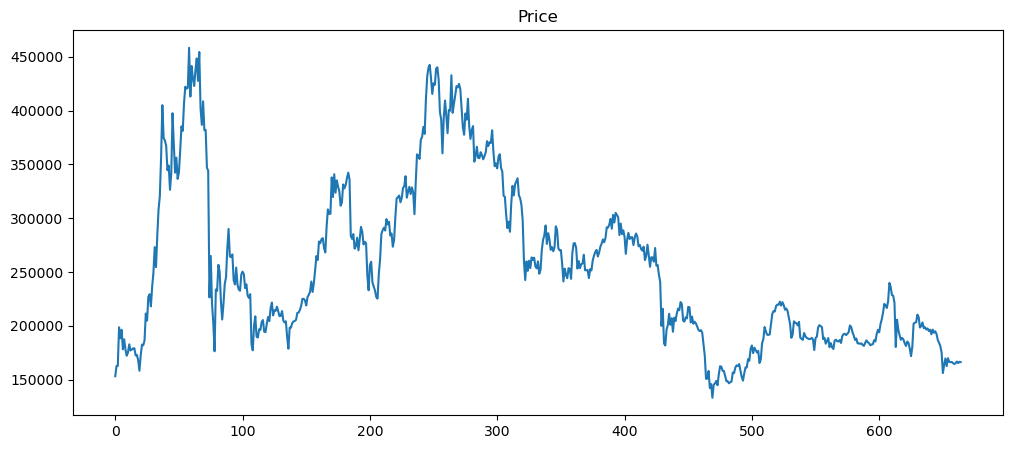

In [43]:
# check the training performance

plt.figure(figsize=(12, 5))
plotBarColoredSign(y_train * output_scale)
plt.title('Profit of future')
plt.show()

prediction = model2.predict(x_train)
prediction = prediction.reshape(-1) * output_scale
plt.figure(figsize=(12, 5))
plotBarColoredSign(prediction)
plt.title('Prediction')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(input_data[0:len(x_train)] * input_scale)
plt.title('Price')
plt.show()

In [49]:
# model3.save('models/model6-3')
model3.load_weights('models/model6-3')


Epoch 13: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.

Epoch 21: ReduceLROnPlateau reducing learning rate to 5.000000237487257e-06.

Epoch 26: ReduceLROnPlateau reducing learning rate to 5.000000328436726e-07.

Epoch 31: ReduceLROnPlateau reducing learning rate to 5.000000555810402e-08.
Restoring model weights from the end of the best epoch: 16.

Epoch 36: ReduceLROnPlateau reducing learning rate to 5.000000413701855e-09.
Epoch 36: early stopping
Early stopping restore at 15 epochs
10/10 [==============================] - 2s 22ms/step - loss: 0.2105 - mse: 0.2105
loss: 0.4588371690105282
corr: 0.2091912299506862


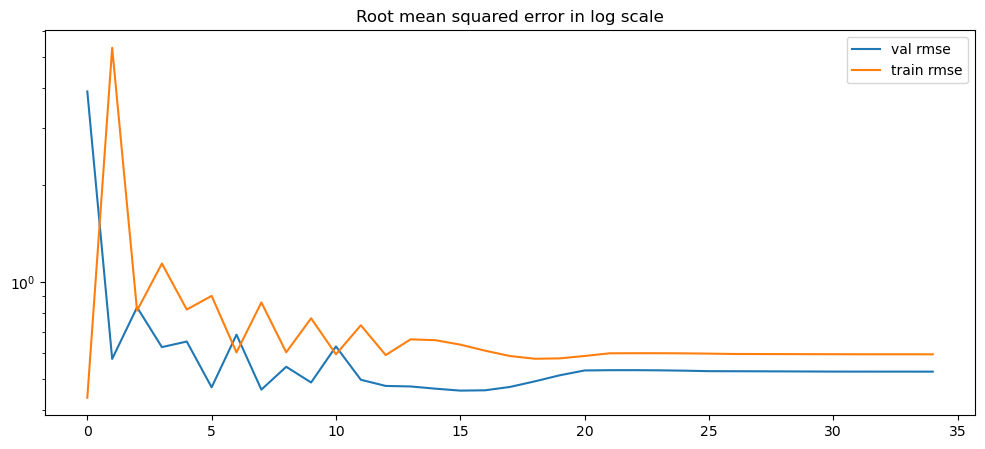

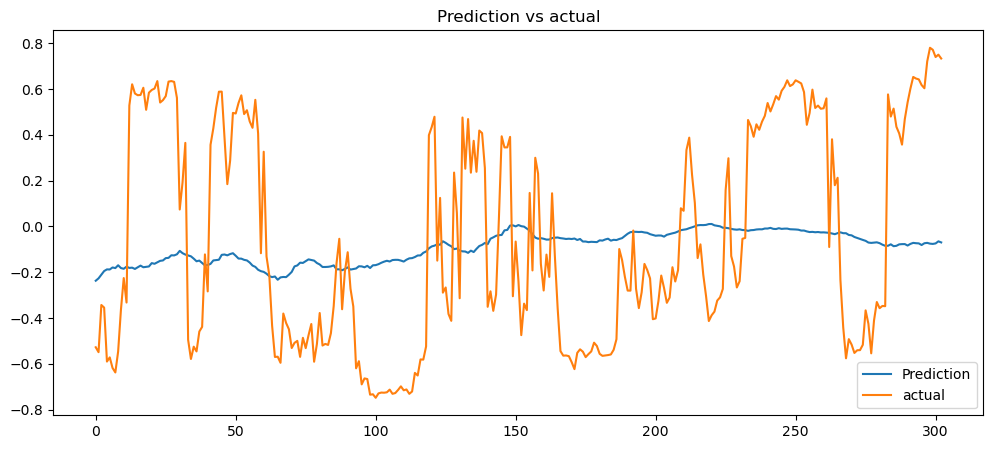

In [50]:
model3.compile(loss="mse",
              optimizer=tf.keras.optimizers.Adam(0.0005),
              metrics=["mse"])

history3, rmse3, corr3 = standardTrainingAndReport(model3, x_test, y_test, train_dataset, test_dataset)

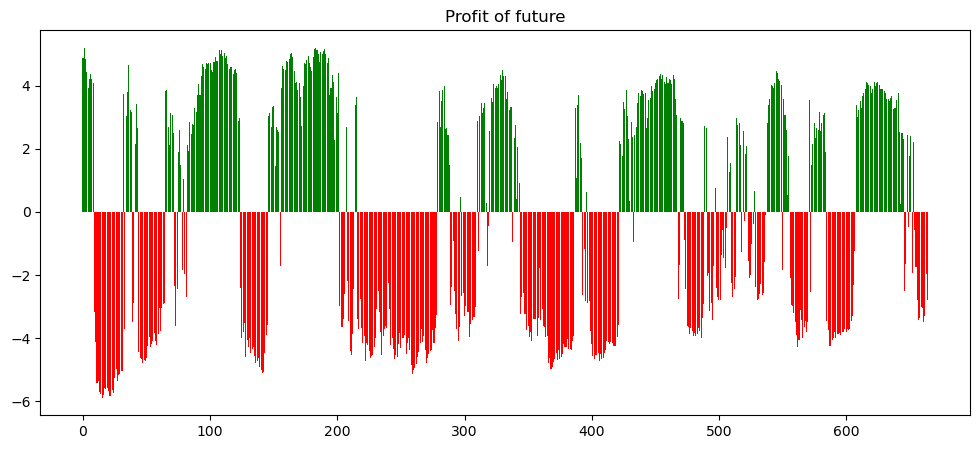

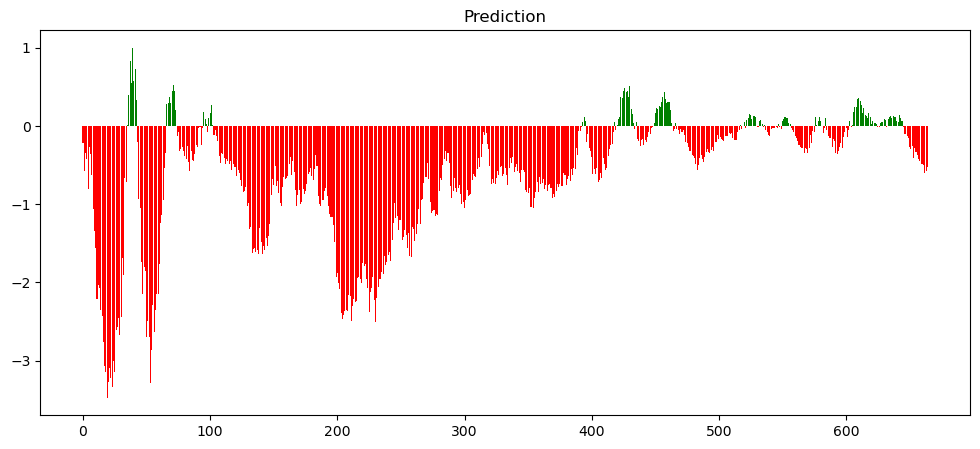

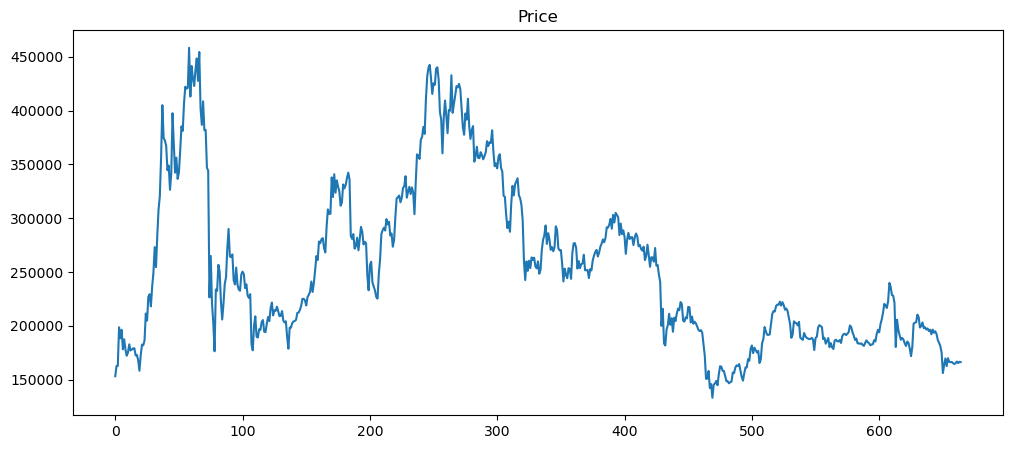

In [51]:
# check the training performance

plt.figure(figsize=(12, 5))
plotBarColoredSign(y_train * output_scale)
plt.title('Profit of future')
plt.show()

prediction = model2.predict(x_train)
prediction = prediction.reshape(-1) * output_scale
plt.figure(figsize=(12, 5))
plotBarColoredSign(prediction)
plt.title('Prediction')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(input_data[0:len(x_train)] * input_scale)
plt.title('Price')
plt.show()

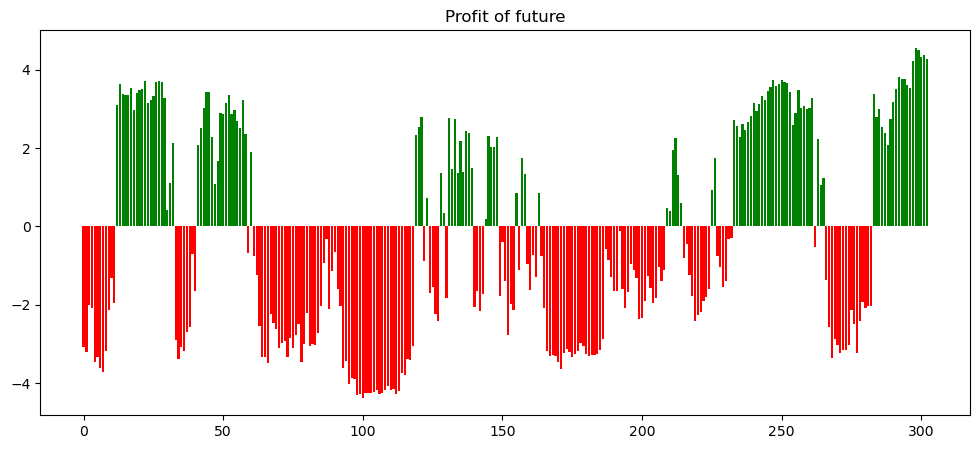

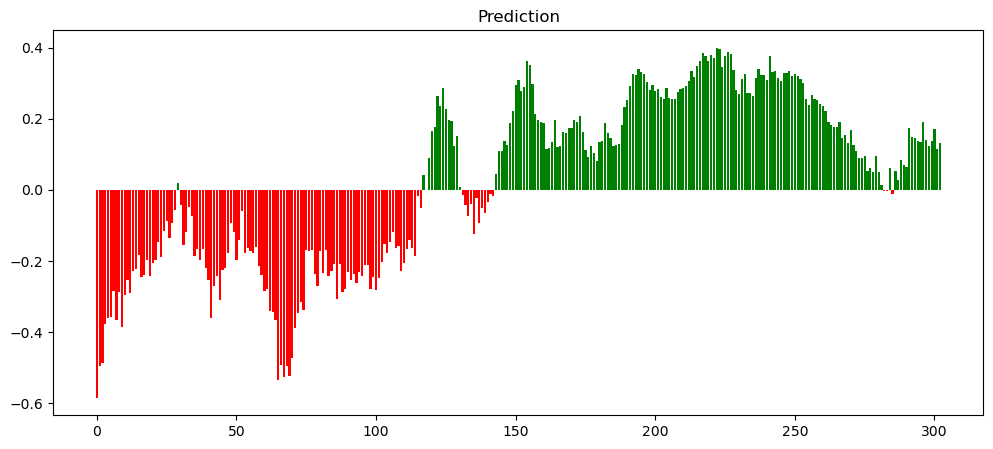

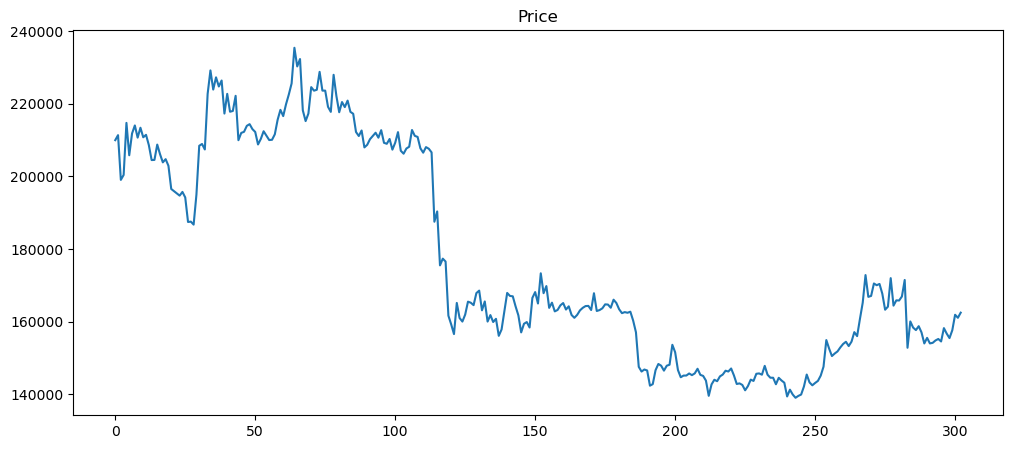

In [52]:
# check the testing performance

plt.figure(figsize=(12, 5))
plotBarColoredSign(y_test * output_scale)
plt.title('Profit of future')
plt.show()

prediction = model2.predict(x_test)
prediction = prediction.reshape(-1) * output_scale
plt.figure(figsize=(12, 5))
plotBarColoredSign(prediction)
plt.title('Prediction')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(input_data[-len(x_test):] * input_scale)
plt.title('Price')
plt.show()
